In [2]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [3]:
dpe = DPE('COM6')

Running <function DPE.init_dut at 0x0F7655D0> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected


In [4]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

In [5]:
dpe.set_clock(50)

Running <function DPE.set_clock at 0x0F7656F0> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [6]:
g = dpe.read(1) 

Running <function DPE.read at 0x0F765780> with serial
[INFO] Elapsed time = 0.29s
Serial disconnected


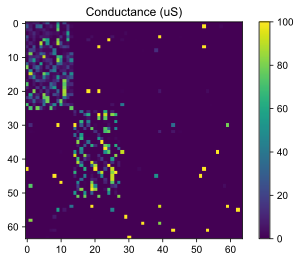

In [7]:
plt.imshow(g * 1e6)
plt.clim(0, 100)
plt.colorbar()
plt.title('Conductance (uS)')

plt.savefig('Gconv.eps')

In [8]:
nn = NN_dpe(weights)

In [20]:
img_idx = 0

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [21]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2

Running <function DPE.multiply at 0x0F7659C0> with serial
[INFO] Elapsed time = 3.28s
Serial disconnected


In [22]:
outputs.shape

(400, 14)

In [23]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

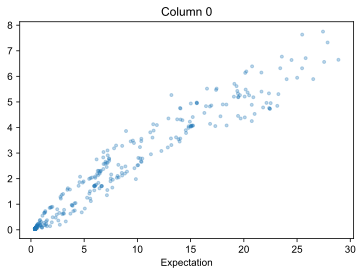

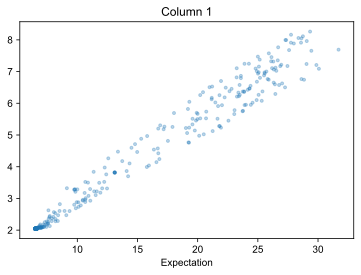

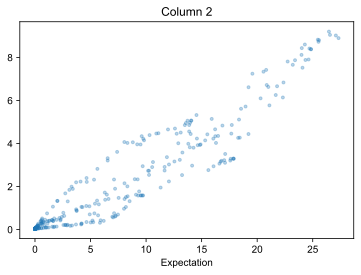

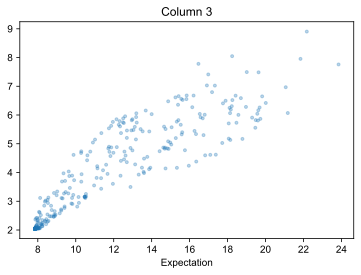

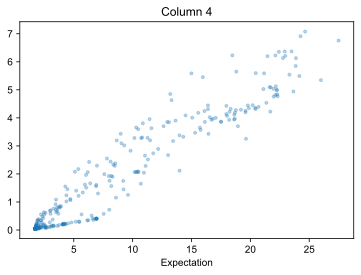

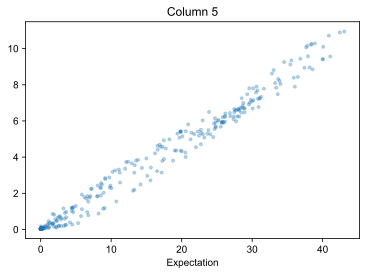

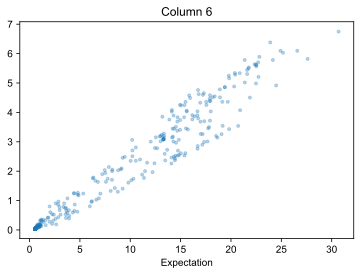

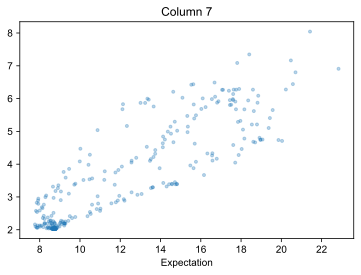

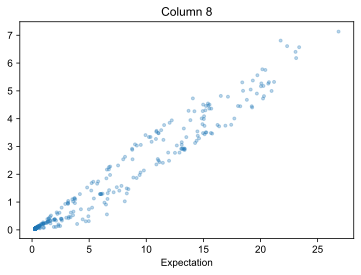

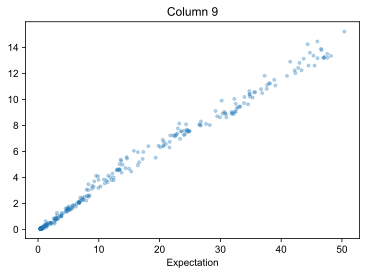

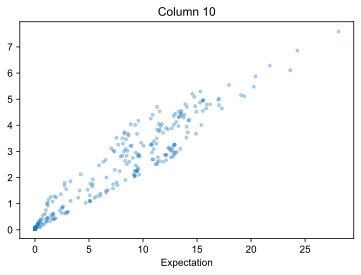

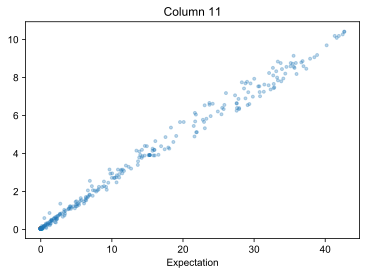

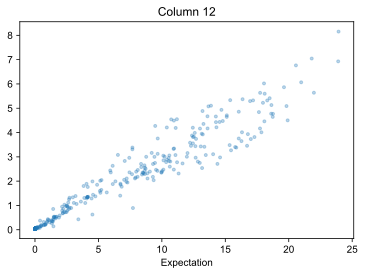

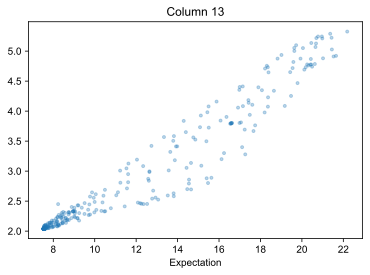

In [24]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

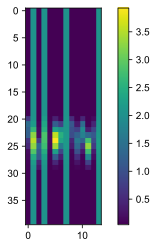

In [25]:
plt.imshow(software[:40])
plt.colorbar()

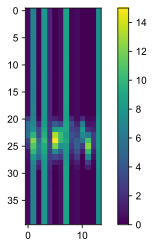

In [26]:
plt.imshow(outputs[:40])
plt.colorbar()

In [27]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 0.26372767,  0.07312113],
       [ 0.25389602,  0.39717563],
       [ 0.29825611, -0.06348742],
       [ 0.41399532, -0.96089218],
       [ 0.26340217, -0.38326686],
       [ 0.2420626 , -0.0117708 ],
       [ 0.2343455 , -0.0971123 ],
       [ 0.36558352, -0.93522793],
       [ 0.26281594, -0.06653043],
       [ 0.29702146,  0.03752489],
       [ 0.28607907,  0.1116195 ],
       [ 0.24340576,  0.1051352 ],
       [ 0.27755834,  0.08840592],
       [ 0.21127688,  0.40756376]])

In [28]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [29]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

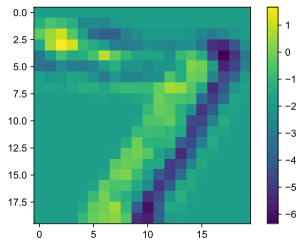

In [33]:
plt.imshow(x[:,:,0])
plt.colorbar()

In [30]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 7
label 7


In [ ]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

In [103]:
load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [104]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [105]:
xs

array([[ 1.43760178, -0.        ,  2.6677077 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.40300978,  0.68757231,  2.79176243, ..., -0.        ,
         3.54113916,  2.61077068],
       [-0.        , -0.        ,  0.06726302, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.11108644, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.11126897, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.79958419, ..., -0.        ,
         3.2943451 ,  1.30286908]])

In [106]:
xs = np.array(xs)
xs.shape

(10000, 112)

In [107]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [108]:
xs.shape

(10000, 113)

Running <function DPE.read at 0x0E2E3DF8> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


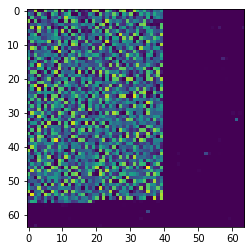

In [109]:
plt.imshow(dpe.read(2))

In [110]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [111]:
dpe.N_BIT = 8

output1 = dpe.multiply(2, x1, c_sel=[0, 20], mode=0)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(2, x2, c_sel=[20, 40], mode=0)
software2 = (Gfc2.T @ x2).T 

Running <function DPE.multiply at 0x0E2E4078> with serial
[INFO] Elapsed time = 2.07s
Serial disconnected
Running <function DPE.multiply at 0x0E2E4078> with serial
[INFO] Elapsed time = 2.06s
Serial disconnected


In [112]:
# dpe.N_BIT = 8
# output1 = dpe.multiply_w_delay(2, x1, c_sel=[0, 20], mode=1, debug=True, delay=5)
# software1 = (Gfc1.T @ x1).T 

# output2 = dpe.multiply_w_delay(2, x2, c_sel=[20, 40], mode=1, debug=True, delay=5)
# software2 = (Gfc2.T @ x2).T 

In [113]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [114]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [115]:
# output_cor = lin_corr(output_sub, lin_cor_fc)

In [116]:
# for c in range(10):
#     x = software_sub[:,c]
#     y = output_cor[:,c]
    
#     plt.plot(x,y,'.')
#     plt.xticks(rotation=45)

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

In [117]:
outputs = dpe.multiply(0, x2, c_sel=[20, 40], mode=0) 
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Running <function DPE.multiply at 0x0E2E4078> with serial
[INFO] Elapsed time = 2.01s
Serial disconnected


In [118]:
# outputs = dpe.multiply_w_delay(2, x2, c_sel=[20, 40], mode=1, debug=True, delay=5)
output_corr = lin_corr(output2, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

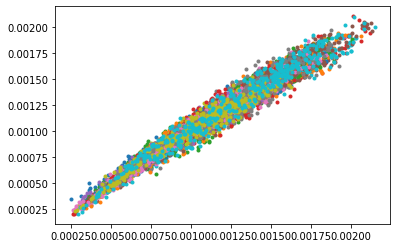

In [119]:
# lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
    plt.plot(x,y,'.')

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([  1.,   0.,   2.,   3.,   2.,   7.,   7.,  10.,   7.,  24.,  29.,
         30.,  49.,  70.,  74., 101., 102., 141., 159., 212., 232., 252.,
        331., 378., 480., 553., 578., 542., 516., 458., 450., 386., 371.,
        304., 265., 211., 199., 133., 108.,  72.,  50.,  42.,  23.,  16.,
          7.,   5.,   3.,   2.,   1.,   2.]),
 array([-0.12070748, -0.11627144, -0.1118354 , -0.10739936, -0.10296333,
        -0.09852729, -0.09409125, -0.08965521, -0.08521917, -0.08078314,
        -0.0763471 , -0.07191106, -0.06747502, -0.06303899, -0.05860295,
        -0.05416691, -0.04973087, -0.04529483, -0.0408588 , -0.03642276,
        -0.03198672, -0.02755068, -0.02311465, -0.01867861, -0.01424257,
        -0.00980653, -0.00537049, -0.00093446,  0.00350158,  0.00793762,
         0.01237366,  0.01680969,  0.02124573,  0.02568177,  0.03011781,
         0.03455385,  0.03898988,  0.04342592,  0.04786196,  0.052298  ,
         0.05673403,  0.06117007,  0.06560611,  0.07004215,  0.07447819,
 

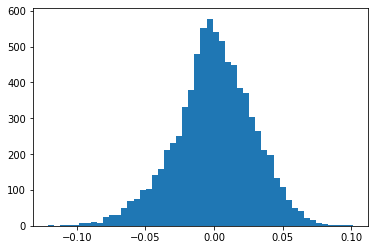

In [120]:
plt.hist((output_corr-software).reshape(-1, 1)/0.0025, bins=50 )

In [121]:
(output_corr-software).reshape(-1, 1).std()/0.00225

0.03174224690830441

In [96]:
# load_workspace(vars(), '20190821-051552-mnist_xs')
# xs = np.array(xs)

In [97]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20], mode=1)
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40], mode=1)
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Batch accuracy = 92.10%
Overall = 92.02%


In [85]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9377

In [86]:
save_workspace(vars(), note='prober1-reprogFC-unary64')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>), sc1(<class 'numpy.float64'>), sc2(<class 'numpy.float64'>), Gfc1(<class 'numpy.ndarray'>), Gfc2(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), software1(<class 'numpy.ndarray'>),

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [23]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

In [104]:
# Linear correction after subtraction

ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20], mode=1) * sc1
#     output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40], mode=1) * sc2
#     output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    y = lin_corr(y, lin_cor_fc)
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Batch accuracy = 89.00%
Overall = 89.61%
